In [2]:
import numpy as np
import random
import math
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from gga import GGA

In [3]:
data=pd.read_csv('HistoricalQuotes.csv')
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [4]:
#rename column to remove spaces in column names
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})


In [5]:
#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')


In [6]:
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)
aapl.head()

,Date,close,volume,open,high,low
2517,2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500
2516,2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771
2515,2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057
2514,2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
2513,2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614


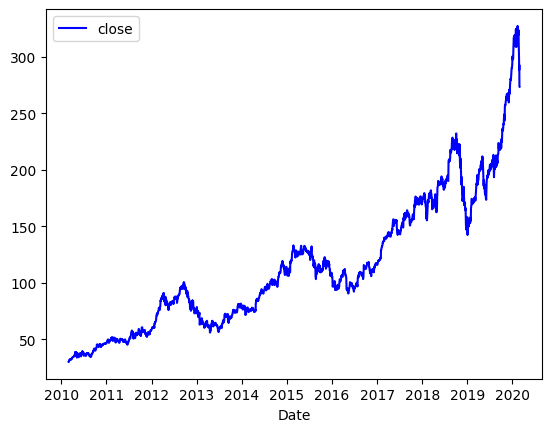

In [7]:
color = 7*['blue']
color[-1]='red'
aapl.plot(x='Date', y='close',color=color)
plt.show()

In [8]:
#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)                     

In [9]:
#  """Based on parameter setting adopted in Chen et al (2021) """

def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1_CONDITIONS':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2_CONDITIONS':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3_CONDITIONS':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4_CONDITIONS':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5_CONDITIONS': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6_CONDITIONS': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7_CONDITIONS': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8_CONDITIONS': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies


In [10]:
data, strategies =generate_candidate_trading_signals(aapl.copy())
data.head()

,Date,close,volume,open,high,low,5EMA,20EMA,RSI,WILLR,...,MACDHIST,DMI,TS1_CONDITIONS,TS2_CONDITIONS,TS3_CONDITIONS,TS4_CONDITIONS,TS5_CONDITIONS,TS6_CONDITIONS,TS7_CONDITIONS,TS8_CONDITIONS
2517,2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2516,2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2515,2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2514,2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2513,2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614,30.19514,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [11]:
 #def __init__(self,data, K,pSize,strategies,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
g = GGA(data,3,10,strategies,0.8,0.01,0.3,10,4,4,-0.15,0.15,1000)

In [12]:
g.evolve()

In [13]:
g.best

[[1, 1, 1, 1, 1, 1, 1, 1],
 [['TS8_CONDITIONS', 'TS7_CONDITIONS', 'TS5_CONDITIONS'],
  ['TS5_CONDITIONS', 'TS1_CONDITIONS', 'TS3_CONDITIONS', 'TS6_CONDITIONS'],
  ['TS2_CONDITIONS', 'TS4_CONDITIONS', 'TS6_CONDITIONS']],
 [1, 0, 1, 0, 1, 1, 1],
 173.98440600665168]

In [14]:
# select trading strategy according to SLTP

def generate_trading_signal(data,strategy,stop_loss,take_profit):
    total_strategy_return = 0
    trade_freq = 0
    market_position = 'out'
    max_loss = 0
    for row in data.itertuples(index=False): 
        if market_position == 'out' :
            if row[data.columns.get_loc(strategy)] == 1:
                cost_price = row.close
                market_position = 'in'
        else:
            sell_price = row.close
            trade_return = round(((sell_price - cost_price)/cost_price),2)
            if trade_return <= stop_loss or trade_return >= take_profit: 
                trade_freq +=1
                if trade_return < max_loss:
                    max_loss = trade_return
                total_strategy_return += trade_return
                market_position = 'out'   
            if row[data.columns.get_loc(strategy)] == 0 and trade_return >= take_profit :
                market_position = 'out'
                trade_freq +=1
                if trade_return < max_loss:
                    max_loss = trade_return
                total_strategy_return += trade_return
    avg_return = round(total_strategy_return/trade_freq,2)
    strategy_performance ={strategy: {"avg_return":avg_return,"mdd":max_loss,"frequency":trade_freq}}
    
    return strategy_performance



In [15]:
def generateSLTP(n,b):
    """Generate bits for SLTP Part"""
    l = n + b
    sltp= [random.randint(0, 1) for _ in range(l)]
    
    return sltp

def binary_to_sltp(sltp,n,b,sl_boundary,tp_boundary):
    """CONVERT SLPT Part to float"""
    
    sl_part,tp_part = sltp[:n],sltp[n:]
    max_sl = sum([np.power(2,i)*1 for i in range(len(sl_part))])
    max_tp = sum([np.power(2,i)*1 for i in range(len(tp_part))])
    sl_part.reverse()
    tp_part.reverse()
    sl  = sum([np.power(2,i)*sl_part[i] for i in range(len(sl_part))])
    tp  = sum([np.power(2,i)*tp_part[i] for i in range(len(tp_part))])
    sl = sl_boundary/max_sl * sl
    tp = tp_boundary/max_tp * tp
    return sl,tp

def strategy_performance(data,strategies,sltp,n,b,stop_loss,take_profit):
    sl, tp = binary_to_sltp(sltp,n,b,stop_loss,take_profit)
    strategy_performance = {}
    for strategy in strategies:
        a = generate_trading_signal(data,strategy,sl,tp)
        
        strategy_performance[strategy]= a[strategy]
    return strategy_performance

def generateGroup(K,strategies):
    """Generate Group and assign TS to groups K"""
    x = strategies.copy()
    random.shuffle(x)
    groups = [[] for k in range(K)]
    while x:
        s = x.pop()
        random_index = random.randrange(K)
        groups[random_index].append(s)
    return groups

def generateWeight(K,num_weight):
    """Generate Weight Part and assign to groups K"""
    weights= [1 for _ in range(num_weight)]
    K = K+1
    for i in range(K):
        random_index = random.randrange(K)
        weights[random_index] = 0
    return weights

def init_population(pSize,n,b,K,num_weight,strategies):
    population =[]
    for i in range(pSize):
        chromosome = [] #c = [[SLTP],[[K],[Weight]]
        chromosome.append(generateSLTP(n,b)) #SLPT PART
        chromosome.append(generateGroup(K,strategies)) # TS & Group Part"
        chromosome.append(generateWeight(K,num_weight)) #Weight Part
        chromosome.append(1) #fitness
        population.append(chromosome)
    
    return population




In [16]:
 #Fitness Function
    
def get_max_min(p4mc,metric):
    modified ={}
    for i in  p4mc:
        modified[i] = p4mc[i][metric]
    max_key= max(modified, key=modified.get)
    min_key = min(modified, key=modified.get)
    
    return modified[max_key], modified[min_key]


    
def getRisk(p4mc,chromosome):
    all_tsp = 0
    for i in range(len(chromosome[1])):
        
        tsp =[]
        for j in chromosome[1][i]:
            tsp.append(p4mc[j]['mdd'])
        if tsp:
            mdd = min(tsp)
        else:
            mdd =0
        all_tsp += mdd
    all_tsp = all_tsp/len(chromosome[1])
    return all_tsp

def normalisation(p4mc,metric):
    max_value,min_value = get_max_min(p4mc,metric)
    for i in p4mc:
        p4mc[i][metric] = (p4mc[i][metric] - min_value )/ (max_value - min_value)
    return p4mc

def getWeights(weightPart,K):
    w = weightPart.copy()
    L = sum([i for i in w if i == 1])
    K = K+1
    z = {k: [] for k in range(K)}
    for i in range(K):
        while w:
                x = w.pop(0)
                if x == 0:
                    break
                else:

                    z[i].append(x)
    
    return z
    


def getProfit(p4mc,chromosome,allocated_capital,K):
    weights = getWeights(chromosome[2],K)
    w = chromosome[2]
    L = sum([i for i in w if i == 1])
    for i in weights:
        try:
            weights[i]= round(len(weights[i])/L,2)
        except ZeroDivisionError:
            weights[i] = 0
    total = 0
    for i in range(len(chromosome[1])):
        for j in chromosome[1][i]:
            total += p4mc[j]['avg_return']*weights[i+1]*allocated_capital
    return total

def groupBalance(chromosome,N):
    gb = 0
    for group in chromosome[1]:
        try:
            g_result = len(group)/N
        except ZeroDivisionError:
            g_result = 0
        if g_result == 0:
            g =0
        else:
            g = -g_result * np.log(g_result)
        gb += g
    return gb

def weightBalance(chromosome,K):
    gb = 0
    TL = sum([i for i in chromosome[2] if i == 1])
    weights = getWeights(chromosome[2],K)
    
    for i in weights:
        try:
            w = len(weights[i])/TL
        except ZeroDivisionError:
            w = 0
        if w == 0:
            wb = 0  
        else:
            wb = -w * np.log(w)
        if wb:
            gb += wb
    return gb

def fitness_function(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K):
    performance = strategy_performance(data,strategies,chromosome[0],n,b,stop_loss,take_profit)
    p4mc = normalisation(performance,'mdd')
    profit =getProfit(p4mc,chromosome,allocated_capital,K)
    risk = getRisk(p4mc,chromosome)
    
    gb = groupBalance(chromosome,len(strategies))
 
    wb = weightBalance(chromosome,K)
    fitness = profit * risk * np.power(gb,2) * wb
    chromosome[3] = fitness 
    return chromosome


In [17]:
data,strategies =  generate_candidate_trading_signals(aapl.copy())
popu = init_population(3,4,4,3,9,strategies)
chromosome= popu[2]
fitness_function(chromosome,strategies,4,4,-0.15,0.15,1000,3)

[[1, 1, 0, 0, 1, 1, 0, 1],
 [['TS6_CONDITIONS', 'TS3_CONDITIONS', 'TS5_CONDITIONS', 'TS2_CONDITIONS'],
  ['TS1_CONDITIONS', 'TS8_CONDITIONS', 'TS7_CONDITIONS', 'TS4_CONDITIONS'],
  []],
 [0, 0, 0, 1, 1, 1, 1, 1, 1],
 0.0]

In [19]:
# Select parents

def roulette_wheel_selection(population):
  
    # Computes the totallity of the population fitness
    population_fitness = sum([chromosome[3] for chromosome in population])
    
    # Computes for each chromosome the probability 
    chromosome_probabilities = [chromosome[3]/population_fitness for chromosome in population]
    # Selects one chromosome based on the computed probabilities
    population = np.array(population,dtype=object)
    output = population[np.random.choice(population.shape[0],p=chromosome_probabilities)]
    
    return list(output)#np.random.choice(population, p=chromosome_probabilities)

def selection(population):
    selected = []
    for i in range(len(population)):
        selected.append(roulette_wheel_selection(population))
    return selected


In [20]:
### Crossover
def crossover(parent1,parent2,r_cross):
    child1 = parent1
    child2 = parent2
    # check for recombination
    if random.random() < r_cross:
        # select crossover point that is not on the end of the string
        index = random.randint(1, len(parent1[0])-2)
        # perform crossover on SLTP
        child1[0] = parent2[0][:index] + parent1[0][index:]
        child2[0] = parent1[0][:index] + parent2[0][index:]
        # perform crossover on weight
        index = random.randint(1, len(parent1[2])-2)
        child1[2] = parent2[2][:index] + parent1[2][index:]
        child2[2] = parent1[2][:index] + parent2[2][index:]
    return child1,child2

    

In [37]:
###Mutation

def mutation(chromosone, r_mut):
    # on SLTP
    for i in range(len(chromosone[0])):
        # check for a mutation
        if random.random() < r_mut:
            # flip the bit
            chromosone[0][i] = 1 - chromosone[0][i]
     # on Weight Part
    for i in range(len(chromosone[2])):
        # check for a mutation
        if random.random() < r_mut:
            # flip the bit 
            chromosone[2][i] = 1 - chromosone[2][i] 
    # on TS part
    e = random.random()
    print(e)
    if e < r_mut:
            grp_idx1 = random.randrange(len(chromosome[1]))
            grp_idx2 = random.randrange(len(chromosome[1]))
            ts_idx = random.randrange(len(chromosome[1][grp_idx1]))
            ts = chromosome[1][grp_idx1][ts_idx]
            chromosome[1][grp_idx2].append(ts)
            
    return chromosone
population =init_population(3,4,4,3,9,strategies)
print(population[0])
print("================")
c =mutation(population[0],0.99) 

print("Inverted : {}".format(c))
print("=================")
    

[[1, 0, 0, 1, 0, 1, 1, 0], [['TS7_CONDITIONS', 'TS5_CONDITIONS'], ['TS8_CONDITIONS', 'TS6_CONDITIONS', 'TS3_CONDITIONS', 'TS4_CONDITIONS'], ['TS2_CONDITIONS', 'TS1_CONDITIONS']], [0, 0, 1, 0, 1, 1, 1, 1, 1], 1]
0.37780016081456425
Inverted : [[0, 1, 1, 0, 1, 0, 0, 1], [['TS7_CONDITIONS', 'TS5_CONDITIONS'], ['TS8_CONDITIONS', 'TS6_CONDITIONS', 'TS3_CONDITIONS', 'TS4_CONDITIONS'], ['TS2_CONDITIONS', 'TS1_CONDITIONS']], [1, 1, 0, 1, 0, 0, 0, 0, 0], 1]


In [22]:
###Inversion
def inversion(chromosome, r_inv):
    if random.random() < r_inv:
        inverted = chromosome[1][::-1]
        chromosome[1] = inverted
        #chromosome[1][grp_idx2] = ts_1
    return chromosome
population =init_population(3,4,4,3,9,strategies)
print(population[0])
print("================")
c =inversion(population[0],0.99) 

print("Inverted : {}".format(c))
print("=================")
    

[[0, 0, 1, 0, 1, 1, 1, 1], [['TS6_CONDITIONS', 'TS5_CONDITIONS', 'TS7_CONDITIONS', 'TS3_CONDITIONS', 'TS1_CONDITIONS'], ['TS4_CONDITIONS', 'TS8_CONDITIONS'], ['TS2_CONDITIONS']], [1, 0, 0, 0, 1, 1, 1, 1, 1], 1]
Inverted : [[0, 0, 1, 0, 1, 1, 1, 1], [['TS2_CONDITIONS'], ['TS4_CONDITIONS', 'TS8_CONDITIONS'], ['TS6_CONDITIONS', 'TS5_CONDITIONS', 'TS7_CONDITIONS', 'TS3_CONDITIONS', 'TS1_CONDITIONS']], [1, 0, 0, 0, 1, 1, 1, 1, 1], 1]


In [23]:
##GGA

def gga(data,K,pSize,strategies,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital):
    num_weight = (K*2) + 1
    population = init_population(pSize,n,b,K,num_weight,strategies)
    best = population[0]
    for j in range(n_iter):
        
        for chromosome in population:
            fitness_function(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K)
        tempPopu  = selection(population)
        children = []
        #Crossover
        for i in range(0, len(tempPopu)-1, 2):

                # get selected parents in pairs
                parent1,parent2 = tempPopu[i],tempPopu[i+1]
                #crossover and mutation and inversion 
                child1,child2 = crossover(parent1,parent2,r_cross)
                child1 = mutation(child1, r_mut)
                child2 = mutation(child2, r_mut)
                child1 = inversion(child1, r_inv)
                child2 = inversion(child2, r_inv)
                children.append(child1)
                children.append(child2)
        population = children
        for chromosone in population:
                if chromosone[3] > best[3]:
                    best = chromosone
    return best
        

In [25]:
#Island GA functions

def get_next_process(processes,current_process):
    next_ = int(current_process) + 1
    if next_ >= processes:
        next_ = 0
    return next_

def best_chromosomes(population,N):
    return [i for i in sorted(population, key=lambda x: x[3])[-N:]]



def worst_chromosomes(population,N):
    worst = [i for i in sorted(population, key=lambda x: x[3])[:N]]
    
    for i in worst:
        population.remove(i)
    return population


In [26]:
#split data
train = aapl[(aapl['Date'] <= date(2016,12,31))]
test = aapl[(aapl['Date'] > date(2016,12,31))]

In [32]:
##ISLAND GGA 
import time

def island_gga(populations,island,immigrants,iteration,data,strategies,m_iter,N,K,r_cross,r_mut,r_inv,n,b,stop_loss,take_profit,allocated_capital):
    num_weight = (K*2) + 1
    #best = populations[island][:N]
    
    for chromosome in populations[island]:
        fitness_function(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K)
    tempPopu  = selection(populations[island])
    children = []
    #Crossover
    for i in range(0, len(tempPopu)-1, 2):

            # get selected parents in pairs
            parent1,parent2 = tempPopu[i],tempPopu[i+1]
            #crossover and mutation and inversion 
            child1,child2 = crossover(parent1,parent2,r_cross)
            child1 = mutation(child1, r_mut)
            child2 = mutation(child2, r_mut)
            child1 = inversion(child1, r_inv)
            child2 = inversion(child2, r_inv)
            children.append(child1)
            children.append(child2)
    populations[island] = children
#migration 
    if iteration % m_iter ==0:
        best = best_chromosomes(populations[island],N)# get best
        worst_chromosomes(populations[island],N) # delete worst chromosomes
        #ring topology migration
        if immigrants:
            for i in immigrants:
                # add chromosomes from prev island
                populations[island].append(i)
                #empty the immigrants pool to make way for new immigrants
                immigrants.remove(i)
                
        #add this island best chromosomes to next island
        for chromosome in best:
            immigrants.append(chromosome)
            
            

    return best

def main():
    #island_gga(queue,data,strategies,n_islands,m_iter,N,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
    data,strategies =  generate_candidate_trading_signals(train.copy())
    #lock = Lock()
    n_islands = int(input("islands: "))
    m_iter = int(input("Migration Interval: "))
    N = int(input("Migration Rate: "))
    K = int(input("K: "))
    pSize = int(input("popSize: "))
    r_cross = float(input("Cross over rate: "))
    r_mut = float(input("Mutation Rate: "))
    r_inv = float(input("Inversion Rate: "))
    n_iter = int(input("Number of Generations: "))
    n = int(input("SL: "))
    b = int(input("TP: "))
    stop_loss = float(input("Stop  Loss: "))
    take_profit = float(input("Take Profit: "))
    allocated_capital= float(input("Capital: "))
    num_weight = (K*2) + 1
    gga_start = time.time()
    gga_r = gga(data,K,pSize,strategies,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
    gga_end = time.time()
    print("GGA Result: ")
    print(gga_end-gga_start)
    print("===========")
    print(gga_r)
    print("===========")
    igga_start = time.time()
    populations  = {i: init_population(pSize,n,b,K,num_weight,strategies) for i in range(n_islands)}#
    immigrants = []
    for iteration in range(n_iter):
        for island in populations:
            island_gga(populations,island,immigrants,iteration,data,strategies,m_iter,N,K,r_cross,r_mut,r_inv,n,b,stop_loss,take_profit,allocated_capital)
            
   
    results = best_chromosomes(immigrants,1)
    igga_end = time.time()
    print("===========")
    print("Island GGA Result: ")
    print(igga_end-igga_start)
    print("===========")
    print(results)

if __name__ == "__main__":
    main()

        

ValueError: empty range for randrange()

In [64]:
gga_r=[[0, 1, 0, 1, 0, 0, 0, 1], [['TS4_CONDITIONS', 'TS3_CONDITIONS', 'TS1_CONDITIONS'], ['TS8_CONDITIONS', 'TS5_CONDITIONS', 'TS6_CONDITIONS'], ['TS7_CONDITIONS', 'TS2_CONDITIONS']], [1, 0, 1, 0, 1, 1, 0], 227.65949831290493]
result = [[0, 1, 0, 0, 1, 0, 1, 1], [['TS3_CONDITIONS', 'TS2_CONDITIONS', 'TS6_CONDITIONS', 'TS7_CONDITIONS'], ['TS5_CONDITIONS', 'TS8_CONDITIONS'], [ 'TS4_CONDITIONS', 'TS1_CONDITIONS']], [0, 1, 1, 0, 1, 0, 1], 293.6165399488841]

In [96]:
def getProfit(p4mc,chromosome,allocated_capital,K):
    weights = getWeights(chromosome[2],K)
    w = chromosome[2]
    L = sum([i for i in w if i == 1])
    for i in weights:
        try:
            weights[i]= round(len(weights[i])/L,2)
        except ZeroDivisionError:
            weights[i] = 0
    total = 0
    for i in range(len(chromosome[1])):
        for j in chromosome[1][i]:
            total += p4mc[j]['avg_return']*weights[i+1]*allocated_capital
    return total
def generate_trading_signal(data,strategy,stop_loss,take_profit):
    total_strategy_return = 0
    trade_freq = 0
    market_position = 'out'
    max_loss = 0
    for row in data.itertuples(index=False): 
        if market_position == 'out' :
            if row[data.columns.get_loc(strategy)] == 1:
                cost_price = row.close
                market_position = 'in'
        else:
            sell_price = row.close
            trade_return = round(((sell_price - cost_price)/cost_price),2)
            if trade_return <= stop_loss or trade_return >= take_profit: 
                trade_freq +=1
                if trade_return < max_loss:
                    max_loss = trade_return
                total_strategy_return += trade_return
                market_position = 'out'   
            if row[data.columns.get_loc(strategy)] == 0 and trade_return >= take_profit :
                market_position = 'out'
                trade_freq +=1
                if trade_return < max_loss:
                    max_loss = trade_return
                total_strategy_return += trade_return
    avg_return = round(total_strategy_return,2)
    strategy_performance ={strategy: {"avg_return":avg_return,"mdd":max_loss,"frequency":trade_freq}}
    
    return strategy_performance
gga_performance = strategy_performance(test_data,strategies,gga_r[0],4,4,-0.15,.15)
getProfit(gga_performance,gga_r,1000,3)

1545.0

2605.0


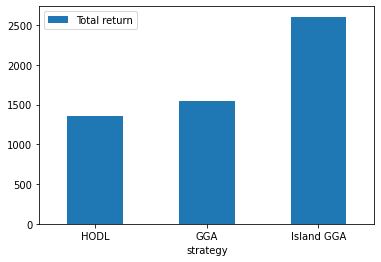

In [103]:
#gga(data,K,pSize,strategies,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
gga_chromosome = gga_r
igga_chromosome = result
test_data,strategies =  generate_candidate_trading_signals(test.copy())
gga_performance = strategy_performance(test_data,strategies,gga_chromosome[0],4,4,-0.15,.15)
gga_profit =getProfit(gga_performance,gga_chromosome,1000,3)
igga_performance = strategy_performance(test_data,strategies,igga_chromosome[0],4,4,-0.15,.15)
igga_profit =getProfit(igga_performance,gga_chromosome,1000,3)
print(igga_profit)
#Buy and Hold Strategy Results
trade_return_ = (test.iloc[-1]['close'] - test.iloc[0]['close'])/test.iloc[0]['close'] 
HODL = round(trade_return_ ,2) *1000 
# multiple lines with legend
l = ["HODL","GGA","Island GGA"]
data = pd.DataFrame([[HODL,gga_profit,igga_profit]],columns=l)
df = pd.DataFrame({'strategy':l, 'Total return':[HODL,gga_profit,igga_profit]})
ax = df.plot.bar(x='strategy', y='Total return', rot=0)

2397.5


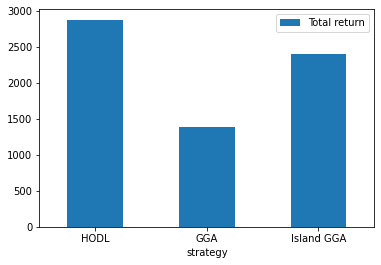

In [104]:
#gga(data,K,pSize,strategies,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
gga_chromosome = gga_r
igga_chromosome = result
train_data,strategies =  generate_candidate_trading_signals(train.copy())
gga_performance = strategy_performance(train_data,strategies,gga_chromosome[0],4,4,-0.15,.15)
gga_profit =getProfit(gga_performance,gga_chromosome,1000,3)
igga_performance = strategy_performance(train_data,strategies,igga_chromosome[0],4,4,-0.15,.15)
igga_profit =getProfit(igga_performance,gga_chromosome,1000,3)
print(igga_profit)
#Buy and Hold Strategy Results
trade_return = (train.iloc[-1]['close'] - train.iloc[0]['close'])/train.iloc[0]['close'] 
HODL = round(trade_return ,2) *1000
# multiple lines with legend
l = ["HODL","GGA","Island GGA"]
data = pd.DataFrame([[HODL,gga_profit,igga_profit]],columns=l)
df = pd.DataFrame({'strategy':l, 'Total return':[HODL,gga_profit,igga_profit]})
ax = df.plot.bar(x='strategy', y='Total return', rot=0)

In [39]:
#Parrell Implementation
from multiprocessing import Process, Queue, Lock,current_process

def island_gga(queue,data,strategies,n_islands,m_iter,N,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital):
    #lock.acquire()
    num_weight = (K*2) + 1
    population = init_population(pSize,n,b,K,num_weight,strategies)
    best = population[0]
    for j in range(n_iter):

        for chromosome in population:
            fitness_function(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K)
        tempPopu  = selection(population)
        children = []
        #Crossover
        for i in range(0, len(tempPopu)-1, 2):

                # get selected parents in pairs
                parent1,parent2 = tempPopu[i],tempPopu[i+1]
                #crossover and mutation and inversion 
                child1,child2 = crossover(parent1,parent2,r_cross)
                child1 = mutation(child1, r_mut)
                child2 = mutation(child2, r_mut)
                child1 = inversion(child1, r_inv)
                child2 = inversion(child2, r_inv)
                children.append(child1)
                children.append(child2)
        population = children
        for chromosone in population:
                if chromosone[3] > best[3]:
                    best = chromosone
        #Migration
        if j % m_iter == 0:
            print("Migration starting", " from island ", current_process().name)
            
            best = best_chromosomes(population,N)# get best and send
        
            worst_chromosomes(population,N) # delete worst chromosomes
            print("Worst Removed !")
            immigrants = queue.get() 
            print("imm..")
            print(immigrants)
            queue.put(best) 
            for immigrant in immigrants:
                population.append(immigrant)
            print("Migration Complete", " from island", current_process().name)

    return best
        
    

def main():
    #island_gga(queue,data,strategies,n_islands,m_iter,N,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
    data,strategies =  generate_candidate_trading_signals(aapl.copy())
    queue = Queue()
    #lock = Lock()
    n_islands = int(input("islands: "))
    m_iter = int(input("Migration Interval: "))
    N = int(input("Migration Rate: "))
    K = int(input("K: "))
    pSize = int(input("popSize: "))
    r_cross = float(input("Cross over rate: "))
    r_mut = float(input("Mutation Rate: "))
    r_inv = float(input("Inversion Rate: "))
    n_iter = int(input("Number of Generations: "))
    n = int(input("SL: "))
    b = int(input("TP: "))
    stop_loss = float(input("Stop  Loss: "))
    take_profit = float(input("Take Profit: "))
    allocated_capital= float(input("Capital: "))
    parent = gga(data,K,pSize,strategies,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
    queue.put(parent)
    print("Parent Done")
    results = queue.get() 
    print(results)
    processes = []
    for i in range(n_islands):
        processes.append(Process(target=island_gga, args=(queue,data,strategies,n_islands,m_iter,N,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital),name=str(i)))
    for p in processes:
        p.start()
    
    for p in processes:
        p.join()
    results = [queue.get() for _ in processes]
    print(results)

if __name__ == "__main__":
    main()

ValueError: invalid literal for int() with base 10: ''

In [ ]:
# multiple lines with legend time
l = ["Island GGA","GGA"]
data = pd.DataFrame([[119.4,96.3]],columns=l)
df = pd.DataFrame({'strategy':l, 'Time':[119.4,96.3]})
ax = df.plot.bar(x='strategy', y='Time', rot=0)